# 📊 Proje: Üretim Makinelerinde Bakım İhtiyacı Tahmini

## 👩‍💻 1. Giriş

### 🎯 Proje Amacı

Bu projenin temel amacı, üretim makinelerine ait sensör verilerini analiz ederek,  
makinelerin bakım gerektirip gerektirmediğini tahmin eden bir **makine öğrenmesi modeli** geliştirmektir.

---

## 📁 2. Veri Seti Hakkında

### 📌 Kullanılan Veri Seti

**Smart Manufacturing IoT-Cloud Monitoring Dataset**

### 📄 Veri Seti İçeriği

#### 🔧 Sensör Verileri:
- 🌡️ **Sıcaklık (Temperature)**
- 📳 **Titreşim (Vibration)**
- 💧 **Nem (Humidity)**
- 🧯 **Basınç (Pressure)**
- ⚡ **Enerji Tüketimi (Energy Consumption)**

#### ⚙️ Makine Durumu:
- 💤 **Idle (Boşta)**
- 🏃 **Running (Çalışıyor)**
- ❌ **Failure (Arızalı)**

#### 🎯 Etiket (Target):
- **Maintenance Required**
  - `1` : Bakım Gerekli
  - `0` : Bakım Gerekli Değil


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\Samira\Sumeyra\btk-akademi\OTÜ Data\data\balanced_sample.csv")

In [3]:
df.describe()

,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,downtime_risk,maintenance_required
count,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000
mean,26.211506,77.222479,51.154848,55.069002,2.971421,2.736041,1.177665,0.233503,191.200508,0.233494,0.500000
std,14.186347,11.196393,15.780467,14.456184,1.145589,1.287416,0.549567,0.423238,156.225167,0.423223,0.500212
min,1.000000,46.190000,6.960000,30.000000,1.010000,0.510000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,14.000000,69.592500,40.302500,42.860000,1.930000,1.620000,1.000000,0.000000,39.000000,0.000000,0.000000
50%,26.000000,76.410000,50.325000,54.795000,2.995000,2.720000,1.000000,0.000000,164.000000,0.000000,0.500000
75%,38.750000,85.205000,61.177500,67.357500,3.967500,3.840000,2.000000,0.000000,325.750000,0.000000,1.000000
max,50.000000,108.070000,98.860000,79.990000,4.990000,5.000000,2.000000,1.000000,499.000000,1.000000,1.000000


In [4]:
import pandas as pd
import numpy as np

def preprocess_time_series_data(df: pd.DataFrame, freq: str = 'h') -> pd.DataFrame:
    """
    Preprocess time series data by:
    1. Converting timestamp to datetime
    2. Sorting by time
    3. Resampling to regular frequency (numeric: median, object: last valid)
    4. Filling missing values
    
    Args:
        df: Input DataFrame with 'timestamp' column
        freq: Resampling frequency (default: 'h' for hourly)
    
    Returns:
        Processed DataFrame with regular time index preserving all columns and dtypes
    """
    # Convert and sort timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Create regular time index
    start_time = df['timestamp'].min().floor(freq)
    end_time = df['timestamp'].max().ceil(freq)
    regular_index = pd.date_range(start=start_time, end=end_time, freq=freq)
    
    # Set timestamp as index
    df = df.set_index('timestamp')
    
    # Store original dtypes
    original_dtypes = df.dtypes.to_dict()
    
    # Separate numeric and non-numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    object_cols = df.select_dtypes(include='object').columns
    
    # Process numeric columns with median
    numeric_df = df[numeric_cols].resample(freq).median() if not numeric_cols.empty else pd.DataFrame()
    
    # Process object columns with last valid observation
    object_df = df[object_cols].resample(freq).last() if not object_cols.empty else pd.DataFrame()
    
    # Combine results
    resampled_df = pd.concat([numeric_df, object_df], axis=1).reindex(regular_index)
    
    # Fill missing values
    # Numeric: forward then backward fill
    if not numeric_cols.empty:
        resampled_df[numeric_cols] = resampled_df[numeric_cols].ffill().bfill()
    
    # Object: forward fill only
    if not object_cols.empty:
        resampled_df[object_cols] = resampled_df[object_cols].ffill()
    
    # Restore original dtypes
    for col, dtype in original_dtypes.items():
        if col in resampled_df.columns:
            # Only convert if the type is different
            if resampled_df[col].dtype != dtype:
                try:
                    resampled_df[col] = resampled_df[col].astype(dtype)
                except (ValueError, TypeError):
                    # If conversion fails (e.g., due to NA values), keep as is
                    pass
    
    return resampled_df

In [5]:
processed_df = preprocess_time_series_data(df, freq='h')

In [6]:
processed_df.describe()

,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,downtime_risk,maintenance_required
count,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.00000,1667.000000,1667.000000,1667.000000,1667.000000
mean,25.674865,77.425159,50.819151,54.701677,2.970156,2.716038,1.09778,0.181764,188.445111,0.224343,0.424115
std,13.165257,10.271314,14.318747,12.917891,1.040428,1.200893,0.52948,0.385765,144.177977,0.390893,0.494356
min,1.000000,46.340000,12.280000,30.000000,1.020000,0.510000,0.00000,0.000000,1.000000,0.000000,0.000000
25%,15.000000,70.400000,40.690000,44.290000,2.150000,1.680000,1.00000,0.000000,44.000000,0.000000,0.000000
50%,25.000000,77.000000,50.115000,54.780000,2.990000,2.720000,1.00000,0.000000,168.000000,0.000000,0.000000
75%,36.000000,84.280000,60.070000,64.725000,3.770000,3.650000,1.00000,0.000000,299.500000,0.500000,1.000000
max,50.000000,105.410000,95.790000,79.990000,4.990000,5.000000,2.00000,1.000000,497.000000,1.000000,1.000000


In [7]:
processed_df.head()

,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,downtime_risk,maintenance_required,failure_type
2025-01-01 00:00:00,21,76.73,34.86,32.64,3.31,1.65,2,0,433,0.0,1,Vibration Issue
2025-01-01 01:00:00,21,76.73,34.86,32.64,3.31,1.65,2,0,433,0.0,1,Vibration Issue
2025-01-01 02:00:00,21,76.73,34.86,32.64,3.31,1.65,2,0,433,0.0,1,Vibration Issue
2025-01-01 03:00:00,24,84.60,45.71,77.43,4.94,1.40,1,0,171,0.0,0,Normal
2025-01-01 04:00:00,24,84.60,45.71,77.43,4.94,1.40,1,0,171,0.0,0,Normal


In [8]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1667 entries, 2025-01-01 00:00:00 to 2025-03-11 10:00:00
Freq: h
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   machine_id                1667 non-null   int64  
 1   temperature               1667 non-null   float64
 2   vibration                 1667 non-null   float64
 3   humidity                  1667 non-null   float64
 4   pressure                  1667 non-null   float64
 5   energy_consumption        1667 non-null   float64
 6   machine_status            1667 non-null   int64  
 7   anomaly_flag              1667 non-null   int64  
 8   predicted_remaining_life  1667 non-null   int64  
 9   downtime_risk             1667 non-null   float64
 10  maintenance_required      1667 non-null   int64  
 11  failure_type              1667 non-null   object 
dtypes: float64(6), int64(5), object(1)
memory usage: 169.3+ KB


In [9]:
df["downtime_risk"].unique()

array([0.  , 1.  , 0.99])

In [10]:
df[df["downtime_risk"] == 0.99]["failure_type"].value_counts()

failure_type
Electrical Fault    1
Name: count, dtype: int64

In [11]:
df.loc[df["downtime_risk"] == 0.99, "downtime_risk"] = 0.0

In [12]:
print(df["downtime_risk"].unique())

[0. 1.]


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# -----------------------------
# 1. Compute the Correlation Matrix
# -----------------------------
# Identify numeric columns in the DataFrame 'data'
numeric_columns = df.select_dtypes(include=['number']).columns

# Compute and round the correlation matrix to 3 decimal places
correlation_matrix = df[numeric_columns].corr().round(3)

# -----------------------------
# 2. Reshape the Correlation Matrix to Long Format
# -----------------------------
# Reset the index and melt the correlation matrix for easier manipulation
correlation_df = correlation_matrix.reset_index().melt(
    id_vars=['index'],
    var_name='Karşılaştırılan Özellik',
    value_name='Korelasyon Değeri'
)
# Rename the index column to 'Özellikler'
correlation_df.rename(columns={'index': 'Özellikler'}, inplace=True)

# -----------------------------
# 3. Enhance the Correlation DataFrame
# -----------------------------
# Filter out self-comparisons (where a feature is compared with itself)
correlation_analysis = correlation_df.query('Özellikler != `Karşılaştırılan Özellik`').copy()

# Calculate the absolute correlation value
correlation_analysis['Mutlak_Korelasyon'] = correlation_analysis['Korelasyon Değeri'].abs()

# Create a feature pair identifier. This ensures that the pair A ↔ B is the same as B ↔ A.
condition = correlation_analysis['Özellikler'] < correlation_analysis['Karşılaştırılan Özellik']
correlation_analysis['Özellik_Çifti'] = np.where(
    condition,
    correlation_analysis['Özellikler'] + ' ↔ ' + correlation_analysis['Karşılaştırılan Özellik'],
    correlation_analysis['Karşılaştırılan Özellik'] + ' ↔ ' + correlation_analysis['Özellikler']
)

# Calculate the explained variance (in percentage) based on the correlation
correlation_analysis['Açıklanan_Varyans'] = (correlation_analysis['Korelasyon Değeri'] ** 2 * 100).round(1)

# Categorize the relationship strength based on absolute correlation
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['Çok Zayıf', 'Zayıf', 'Orta', 'Güçlü', 'Çok Güçlü']
correlation_analysis['İlişki_Gücü'] = pd.cut(
    correlation_analysis['Mutlak_Korelasyon'],
    bins=bins,
    labels=labels,
    right=False
)

# -----------------------------
# 4. Select the Top 10 Unique Correlation Pairs
# -----------------------------
# Remove duplicate feature pairs, sort by the absolute correlation, and select the top 10
unique_correlations = (
    correlation_analysis
    .drop_duplicates('Özellik_Çifti')
    .sort_values('Mutlak_Korelasyon', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# -----------------------------
# 5. Display the Results with Styling
# -----------------------------
# Subset the desired columns and apply a background gradient on 'Mutlak_Korelasyon'
display(
    unique_correlations[['Özellik_Çifti', 'Korelasyon Değeri', 'Mutlak_Korelasyon', 'Açıklanan_Varyans', 'İlişki_Gücü']]
    .style
    .background_gradient(subset=['Mutlak_Korelasyon'], cmap='ocean')
    .format({
        'Korelasyon Değeri': '{:.3f}',
        'Mutlak_Korelasyon': '{:.3f}',
        'Açıklanan_Varyans': '{:.1f}%',
    })
)

,Özellik_Çifti,Korelasyon Değeri,Mutlak_Korelasyon,Açıklanan_Varyans,İlişki_Gücü
0,anomaly_flag ↔ downtime_risk,0.998,0.998,99.6%,Çok Güçlü
1,anomaly_flag ↔ predicted_remaining_life,-0.586,0.586,34.3%,Orta
2,downtime_risk ↔ predicted_remaining_life,-0.584,0.584,34.1%,Orta
3,anomaly_flag ↔ maintenance_required,0.552,0.552,30.5%,Orta
4,downtime_risk ↔ maintenance_required,0.551,0.551,30.4%,Orta
5,anomaly_flag ↔ temperature,0.549,0.549,30.1%,Orta
6,downtime_risk ↔ temperature,0.547,0.547,29.9%,Orta
7,machine_status ↔ maintenance_required,0.508,0.508,25.8%,Orta
8,maintenance_required ↔ predicted_remaining_life,-0.397,0.397,15.8%,Zayıf
9,maintenance_required ↔ temperature,0.332,0.332,11.0%,Zayıf


In [14]:
processed_df = processed_df.drop('anomaly_flag', axis=1)

In [15]:
processed_df['failure_type'].unique()

array(['Vibration Issue', 'Normal', 'Pressure Drop', 'Electrical Fault',
       'Overheating'], dtype=object)

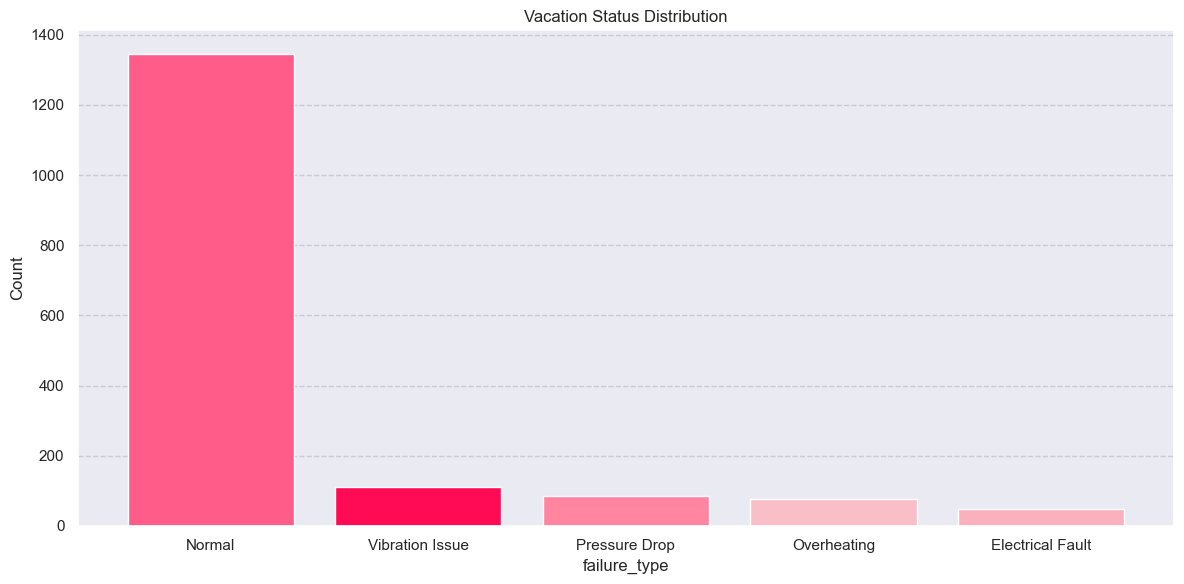

Frekans Tablosu:


,failure_type,Count
0,Normal,1345
1,Vibration Issue,111
2,Pressure Drop,86
3,Overheating,77
4,Electrical Fault,48


In [16]:
# ----------------------
# DEĞİŞKENLERİ AYARLA (Özelleştirin)
# ----------------------
column_name = "failure_type"  # Analiz edilecek sütun
title = "Vacation Status Distribution"  # Grafik başlığı
palette = {'Vibration Issue': '#ff0a54', 'Normal': '#ff5c8a', 'Pressure Drop' : '#ff85a1', 'Electrical Fault': '#fbb1bd', 'Overheating': '#f9bec7'}  # Güncellenmiş renk paleti
edge_color = "white"  # Çubuk kenarlık rengi
figsize = (12, 6)  # Grafik boyutu
grid_style = {"axis": "y", "linestyle": "--", "alpha": 0.3, "color": "gray"}
# ----------------------

# Grafik stilini ve boyutunu ayarla
sns.set(style="dark")
plt.figure(figsize=figsize)

# 1. Sütunun frekanslarını hesapla
value_counts = (
    processed_df[column_name]
    .value_counts()
    .rename_axis(column_name)
    .reset_index(name="Count")
)

# 3. Çubuk grafik oluştur (Palet renklerini kullan)
# Her bir değer için renkleri belirle
bar_colors = [palette[val] for val in value_counts[column_name]]  # Güncellenmiş renk ataması

plt.bar(
    value_counts[column_name], 
    value_counts["Count"], 
    color=bar_colors,
    edgecolor=edge_color
)

plt.xlabel(column_name)
plt.ylabel("Count")
plt.title(title)

# 4. Grid çizgilerini ekle
plt.grid(**grid_style)

# 5. Grafiği göster
plt.tight_layout()
plt.show()

# Frekansları konsola yazdır
print("Frekans Tablosu:")
value_counts

In [17]:
processed_df["machine_status"].unique()

array([2, 1, 0], dtype=int64)

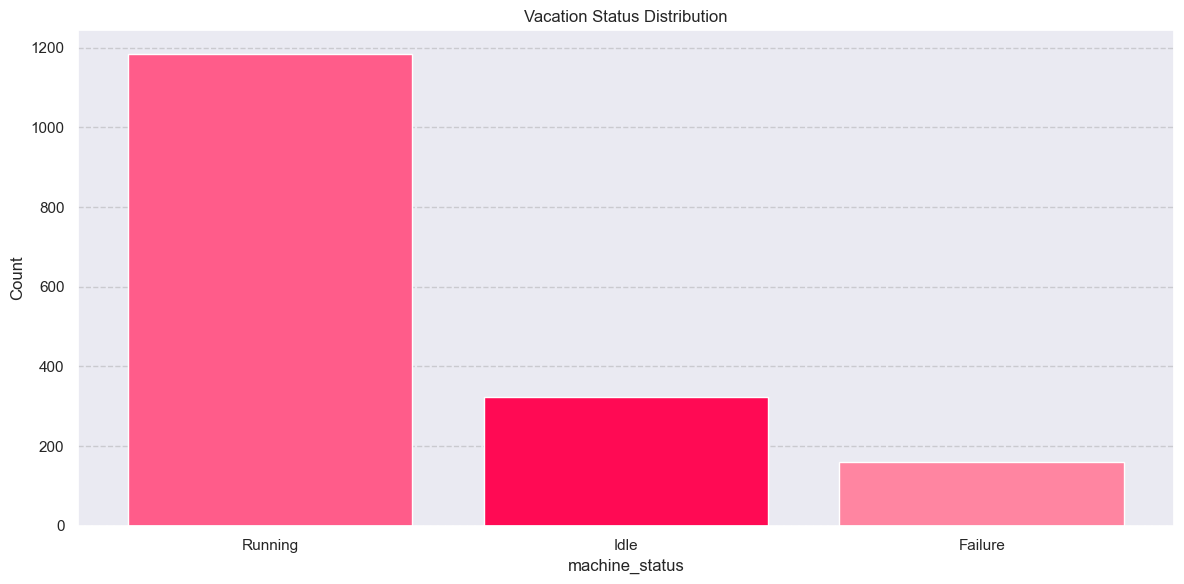

Frekans Tablosu:


,machine_status,Count
0,Running,1184
1,Idle,323
2,Failure,160


In [18]:
# ----------------------
# DEĞİŞKENLERİ AYARLA (Özelleştirin)
# ----------------------
column_name = "machine_status"  # Analiz edilecek sütun
title = "Vacation Status Distribution"  # Grafik başlığı
palette = {'Idle': '#ff0a54', 'Running': '#ff5c8a', 'Failure' : '#ff85a1'}  # Güncellenmiş renk paleti
edge_color = "white"  # Çubuk kenarlık rengi
figsize = (12, 6)  # Grafik boyutu
grid_style = {"axis": "y", "linestyle": "--", "alpha": 0.3, "color": "gray"}
# ----------------------

# Hafta sonu/içi etiketlemesi yap
processed_df[column_name] = processed_df[column_name].map({2: 'Idle', 1: 'Running', 0: 'Failure'})

# Grafik stilini ve boyutunu ayarla
sns.set(style="dark")
plt.figure(figsize=figsize)

# 1. Sütunun frekanslarını hesapla
value_counts = (
    processed_df[column_name]
    .value_counts()
    .rename_axis(column_name)
    .reset_index(name="Count")
)

# 3. Çubuk grafik oluştur (Palet renklerini kullan)
# Her bir değer için renkleri belirle
bar_colors = [palette[val] for val in value_counts[column_name]]  # Güncellenmiş renk ataması

plt.bar(
    value_counts[column_name], 
    value_counts["Count"], 
    color=bar_colors,
    edgecolor=edge_color
)

plt.xlabel(column_name)
plt.ylabel("Count")
plt.title(title)

# 4. Grid çizgilerini ekle
plt.grid(**grid_style)

# 5. Grafiği göster
plt.tight_layout()
plt.show()

# Frekansları konsola yazdır
print("Frekans Tablosu:")
value_counts

In [19]:
processed_df['machine_status'] = pd.Categorical(processed_df['machine_status'], categories=['Idle', 'Running', 'Failure'], ordered=False)

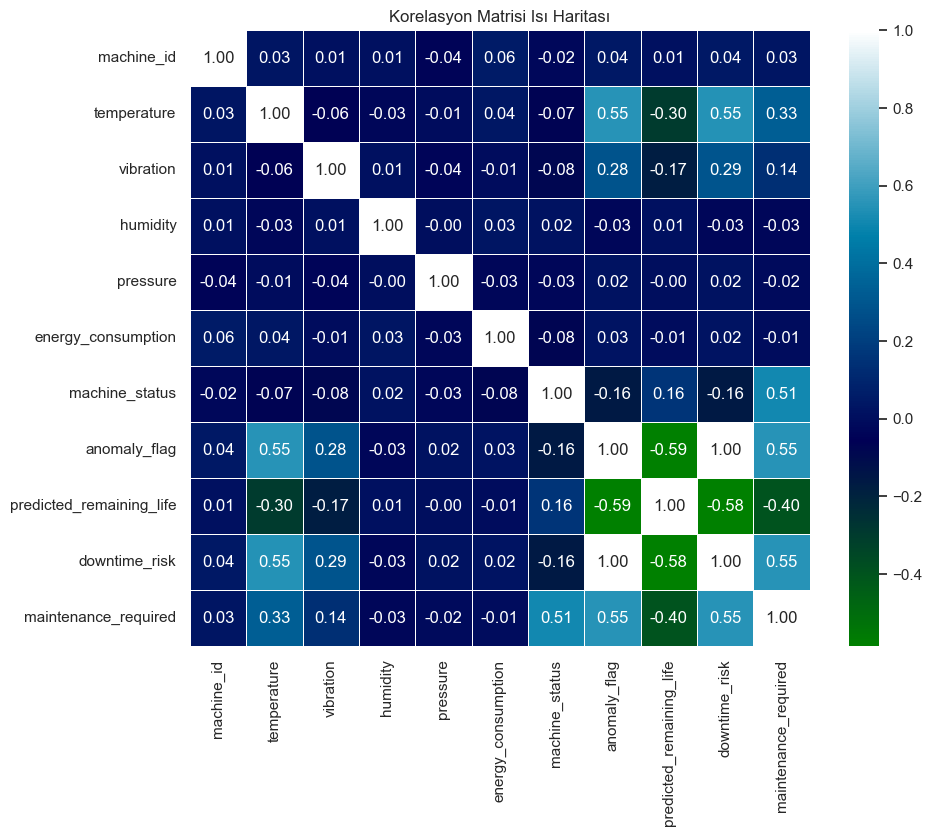

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sadece sayısal sütunlar arasında korelasyon matrisini hesapla
corr = df.corr(numeric_only=True)

# Isı haritası çizimi
plt.figure(figsize=(10, 8))  # Grafik boyutu
sns.heatmap(corr, annot=True, cmap='ocean', fmt=".2f", linewidths=0.5)
plt.title("Korelasyon Matrisi Isı Haritası")
plt.show()

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K



In [22]:
def focal_loss(gamma=2., alpha=0.75):
    def loss_fn(y_true, y_pred):
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1.0 - eps)
        loss = - y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred) \
               - (1 - y_true) * (1 - alpha) * K.pow(y_pred, gamma) * K.log(1 - y_pred)
        return K.mean(loss)
    return loss_fn


In [23]:
def create_sequences(data, labels, window_size):
    X, y = [], []
    for i in range(len(data) - window_size + 1):
        X.append(data[i:i + window_size])
        y.append(labels[i + window_size - 1])
    return np.array(X), np.array(y)


In [24]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import pandas as pd
import numpy as np

# Kategorik değişkenleri one-hot encode et
categorical_cols = processed_df.select_dtypes(include=['object', 'category']).columns
processed_df = pd.get_dummies(processed_df, columns=categorical_cols, drop_first=True)

# ------------------- Öznitelik Grupları -------------------
minmax_cols = ["temperature", "humidity", "predicted_remaining_life"]
robust_cols = ["vibration", "energy_consumption"]
std_cols = ["pressure"]
binary_cols = ["downtime_risk", "maintenance_required"]

# ------------------- Ölçekleyiciler -------------------
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
std_scaler = StandardScaler()

# ------------------- Özelliklerin Ölçeklenmesi -------------------
scaled_minmax = minmax_scaler.fit_transform(processed_df[minmax_cols])
scaled_robust = robust_scaler.fit_transform(processed_df[robust_cols])
scaled_std = std_scaler.fit_transform(processed_df[std_cols])
scaled_binary = processed_df[binary_cols].astype("float32").values

# One-hot encoded sütunları seç (daha önce get_dummies uygulandığı için object tip yok)
encoded_cols = [col for col in processed_df.columns 
                if col not in minmax_cols + robust_cols + std_cols + binary_cols]

scaled_encoded = processed_df[encoded_cols].values.astype("float32")

# ------------------- Tüm Özellikleri Birleştir -------------------
scaled_features = np.concatenate(
    [scaled_minmax,
     scaled_robust,
     scaled_std,
     scaled_encoded,
     scaled_binary[:, 0].reshape(-1, 1)],  # downtime_risk
    axis=1
)

# ------------------- Hedef Değişken -------------------
labels = scaled_binary[:, 1]  # maintenance_required

# ------------------- Sliding Window -------------------
window_size = 10
X, y = create_sequences(scaled_features, labels, window_size)


In [25]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1667 entries, 2025-01-01 00:00:00 to 2025-03-11 10:00:00
Freq: h
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   machine_id                    1667 non-null   int64  
 1   temperature                   1667 non-null   float64
 2   vibration                     1667 non-null   float64
 3   humidity                      1667 non-null   float64
 4   pressure                      1667 non-null   float64
 5   energy_consumption            1667 non-null   float64
 6   predicted_remaining_life      1667 non-null   int64  
 7   downtime_risk                 1667 non-null   float64
 8   maintenance_required          1667 non-null   int64  
 9   machine_status_Running        1667 non-null   bool   
 10  machine_status_Failure        1667 non-null   bool   
 11  failure_type_Normal           1667 non-null   bool   
 12  failure_type_Overh

In [26]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# ------------------- Eğitim/Doğrulama Ayrımı -------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------- SMOTE için Yeniden Şekillendirme -------------------
# SMOTE sadece 2D veri kabul eder (örneğin: (num_samples, num_features))
X_smote = X_train.reshape((X_train.shape[0], -1))  # (samples, window_size * features)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_smote, y_train)

# ------------------- Tekrar 3D Formata Çevir (LSTM gibi modeller için) -------------------
num_features = X.shape[2]  # Özellik sayısını otomatik al
X_resampled = X_resampled.reshape((-1, window_size, num_features))

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Eğer focal loss fonksiyonun tanımlı değilse, aşağıda örnek bir tanımı verilmiştir
import tensorflow.keras.backend as K
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return focal_loss_fixed

# ------------------- Model Oluşturma -------------------
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Girdi boyutu: (window_size, feature_sayısı)
input_shape = (X_resampled.shape[1], X_resampled.shape[2])
model = create_lstm_model(input_shape)

# ------------------- Model Derleme -------------------
model.compile(
    optimizer=Adam(),
    loss=focal_loss(gamma=2., alpha=0.75),
    metrics=['accuracy']
)


C:\Users\Samira\Sumeyra\cwq\coding-with-qiskit\cwq\envs\btk-akademi\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Modeli Eğitme
history = model.fit(
    X_resampled, y_resampled,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)


Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.4903 - loss: 0.1431 - val_accuracy: 0.4247 - val_loss: 0.1333
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5061 - loss: 0.1332 - val_accuracy: 0.6386 - val_loss: 0.1257
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5586 - loss: 0.1290 - val_accuracy: 0.6657 - val_loss: 0.1221
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6146 - loss: 0.1227 - val_accuracy: 0.7259 - val_loss: 0.1123
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6838 - loss: 0.1136 - val_accuracy: 0.7560 - val_loss: 0.1016
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7299 - loss: 0.1019 - val_accuracy: 0.8373 - val_loss: 0.0894
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7990 - loss: 0.0873 - val_accuracy: 0.8524 - val_loss: 0.0711
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8262 - loss: 0.0751 - val_accuracy: 0.8855 - v

In [29]:
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

# ------------------- Modelin Tahminleri -------------------
y_probs = model.predict(X_val).ravel()  # Yalnızca 1. boyutu (y_probs) al

# ------------------- Precision-Recall Eşiği -------------------
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# ------------------- F1 Skoru Hesaplama ve En İyi Eşik Seçimi -------------------
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)  # Küçük bir epsilon ekledim sıfır bölme için
best_thresh = thresholds[np.argmax(f1_scores)]  # En yüksek F1 skoru için eşik

# ------------------- En İyi Eşikle Tahmin Yapma -------------------
y_pred = (y_probs >= best_thresh).astype(int)

# ------------------- Raporlama -------------------
print("Best Threshold:", best_thresh)
print(classification_report(y_val, y_pred))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step 
Best Threshold: 0.59714174
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94       191
         1.0       0.89      0.95      0.92       141

    accuracy                           0.93       332
   macro avg       0.92      0.93      0.93       332
weighted avg       0.93      0.93      0.93       332

